In [1]:
import os
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

/var/folders/qd/qcmv0_xj6ysfn9j044hp74fc0000gn/T/ipykernel_5183/1373641183.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
def download_and_extract(data_dir='data'):
    os.makedirs(data_dir, exist_ok=True)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip"
    zip_path = os.path.join(data_dir, "LD2011_2014.txt.zip")
    txt_path = os.path.join(data_dir, "LD2011_2014.txt")
    if not os.path.exists(txt_path):
        r = requests.get(url)
        with open(zip_path,"wb") as f: f.write(r.content)
        with zipfile.ZipFile(zip_path,"r") as z: z.extractall(data_dir)
    return txt_path

def load_daily_aggregate(txt_path, data_dir='data'):
    processed_path = os.path.join(data_dir, "daily_aggregate.pkl")
    if os.path.exists(processed_path):
        return pd.read_pickle(processed_path)
    df = pd.read_csv(txt_path, sep=';', index_col=0, parse_dates=True)
    df = df.replace(',', '.', regex=True).astype(float)
    df['total'] = df.sum(axis=1)
    daily = df[['total']].resample('D').sum()
    daily.to_pickle(processed_path)
    return daily

txt = download_and_extract()
daily = load_daily_aggregate(txt).loc['2011-01-01':'2014-12-31']
daily['t_day'] = (daily.index - daily.index[0]).days


df = daily.loc['2011-01-01':'2011-12-31']

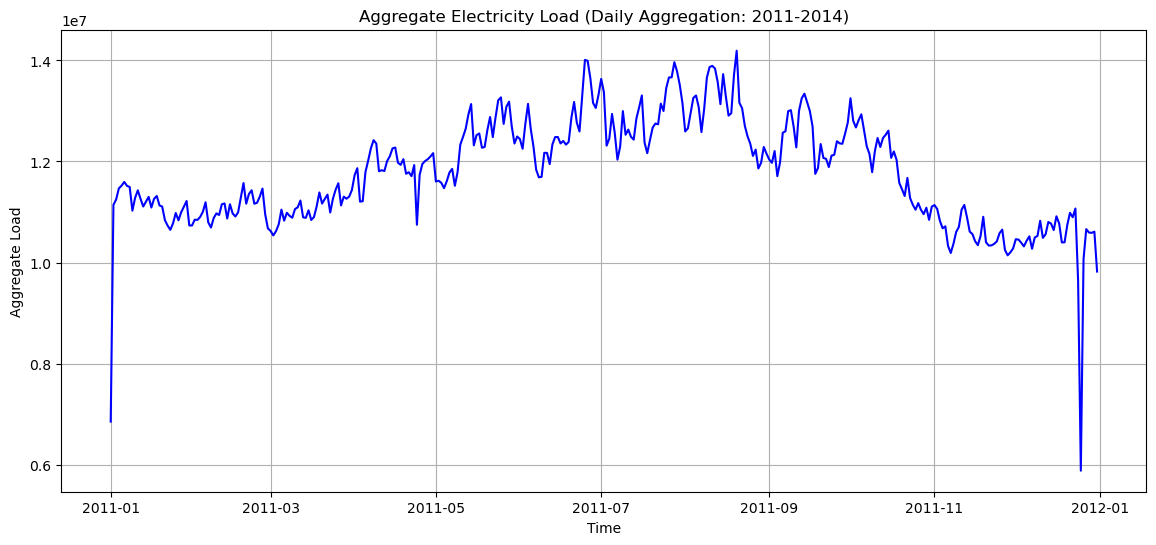

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['total'], color='blue')
plt.title("Aggregate Electricity Load (Daily Aggregation: 2011-2014)")
plt.xlabel("Time")
plt.ylabel("Aggregate Load")
plt.grid(True)
plt.show()

Top 10 wavelengths (days per cycle):
  - 365.0 days per cycle → power = 2.76e+14
  - 182.5 days per cycle → power = 1.25e+13
  - 40.6 days per cycle → power = 8.13e+12
  - 121.7 days per cycle → power = 6.57e+12
  - 24.3 days per cycle → power = 5.44e+12
  - 60.8 days per cycle → power = 5.24e+12
  - 91.2 days per cycle → power = 4.41e+12
  - 33.2 days per cycle → power = 4.09e+12
  - 6.6 days per cycle → power = 3.46e+12
  - 45.6 days per cycle → power = 3.45e+12


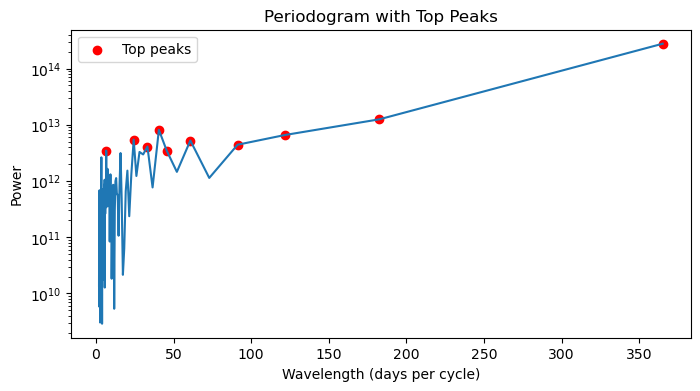

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

freqs, power = periodogram(df['total'].dropna(), fs=1)

mask       = freqs > 0
freqs_pos  = freqs[mask]
power_pos  = power[mask]

wavelengths = 1.0 / freqs_pos

order = np.argsort(wavelengths)
wavelengths = wavelengths[order]
power_pos = power_pos[order]

top_n = 10
idx_desc = np.argsort(power_pos)[::-1]
top_idx = idx_desc[:top_n]
top_wls = wavelengths[top_idx]
top_powers = power_pos[top_idx]

print(f"Top {top_n} wavelengths (days per cycle):")
for wl, pw in zip(top_wls, top_powers):
    print(f"  - {wl:.1f} days per cycle → power = {pw:.2e}")

plt.figure(figsize=(8,4))
plt.semilogy(wavelengths, power_pos)
plt.scatter(top_wls, top_powers, marker='o', c='red', label='Top peaks')
plt.xlabel('Wavelength (days per cycle)')
plt.ylabel('Power')
plt.title('Periodogram with Top Peaks')
plt.legend()
plt.show()


